<a href="https://colab.research.google.com/github/lisasdi/CodePfe/blob/main/Traitement_d'image_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# detectron2

In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#Fonctions traitement image

In [ ]:
#soustraction image et filtre gray
def soustragray(img1,img2):
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  imgs=img1-img2
  return imgs

In [ ]:
#tansformer une photo en matrice
def imagetomatrice(image):
  numpydata = asarray(image) 
  #convertir image en  tableau NumPy
  np_img = numpy.array(image,dtype=np.uint8) 
  npf=np_img  
  return np_img

In [ ]:
#tansformer les autres pixels en blanc
def transformerpixelsblanc(matrice):
   for i in range(0,matrice.shape[0]-1):
      for j in range(0,matrice.shape[1]-1):
          if matrice[i,j]!=0:
             matrice[i,j]=255

In [ ]:
#Enlever le bruit 
def enleverbruit(image):
   kernel = None
   fgmask1 = cv2.erode(np_img, kernel, iterations = 2)
   fgmask = cv2.dilate(fgmask1, kernel, iterations = 25)
   return fgmask


In [ ]:
#squelette
def squelette(image):
  img = image
  size = np.size(img)
  skel = np.zeros(img.shape,np.uint8)
  ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
  element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  done = False
  while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()

    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True
  return skel

In [ ]:
#dilate and crop
def dilate_crop(image):
  kernel = np.ones((6, 6), np.uint8) 
  d_im = cv2.dilate(image, kernel, iterations=1)
  #couper la  photo
  matriceImageNG = np.array(d_im)
  lignes, colonnes = matriceImageNG.shape
  imgcrop=matriceImageNG [10:lignes-20,10:colonnes-20]
  return imgcrop

In [ ]:
#elimination 
def eliminate(image):
  #find all your connected components (white blobs in your image)
  img=image
  nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
  #connectedComponentswithStats yields every seperated component with information on each of them, such as size
  #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
  sizes = stats[1:, -1]; nb_components = nb_components - 1
  # minimum size of particles we want to keep (number of pixels)
  #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
  min_size = 200
  img2 = np.zeros((output.shape))
  #for every component in the image, you keep it only if it's above min_size
  for i in range(0, nb_components):
     if sizes[i] >= min_size:
        img2[output == i + 1] = 255
  return img2

In [ ]:
#traitement matrice
# sauvegarder les valeurs 
def sauvegarderVal(val,valR,liste,lister):
  if val not in liste:
    liste.append(val)
    lister.append(valR)
#trouver les classes
def matriceclasse(mat,liste,listremplace):
  #on va utiiser deux méthodes

   setNumber=1
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):

       if(mat[i,j]==255):
           if (mat[i-1,j] == 0) and (mat[i,j-1] == 0):
               mat[i,j] = setNumber
               setNumber= setNumber+1

           elif (mat[i-1,j] != 0) and (mat[i,j-1] == 0):
                mat[i,j] = mat[i-1,j]
           elif (mat[i-1,j] == 0) and (mat[i,j-1] != 0):
               mat[i,j] = mat[i,j-1]
           elif (mat[i-1,j] != 0) and (mat[i,j-1] != 0):
               if (mat[i-1,j] == mat[i,j-1]):
                  mat[i,j] = mat[i-1,j]
               elif (mat[i-1,j]>mat[i,j-1] and mat[i,j-1] != 0 ):
                  mat[i,j] =mat[i,j-1]
                  sauvegarderVal(mat[i-1,j],mat[i,j-1],liste,listremplace)
              
               else :
                  mat[i,j] = mat[i-1,j]
                  sauvegarderVal(mat[i,j-1],mat[i-1,j],liste,listremplace)

# remplacer les valeur de liste par lister
def remplacedeVal(mat,liste,lister):
  k=0 
  while k< len(liste):
   x=liste[k]
   y=lister[k]
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==x):
         mat[i,j]=y
   k=k+1
#supprimer les valeurs en double
def valeurdouble(liste,lister):
   k=0
   
   while k< len(liste):
    x=liste[k]
    for i in range(0,len(lister)):
     if (lister[i]==x):
         lister[i]=lister[k]
    k=k+1


In [ ]:
#calculer nombre de régions
def calculregion(matrice,listeregion):
    for i in range(0,matrice.shape[0]):
         for j in range(0,matrice.shape[1]):
              if (matrice[i,j]!=0 and matrice[i,j]!=255 ):
                if matrice[i,j] not in listeregion:
                   listeregion.append(matrice[i,j])

       

In [ ]:
#dessin type
#trouver nb pixels pour chaque id
def calculer_nb_id(matrice,id):
  nb=0
  for i in range(0,matrice.shape[0]-1):
     for j in range(0,matrice.shape[1]-1):
         if matrice[i,j]==id:
             nb=nb+1
  return nb 
#recuperer i et j pour chaque region
def i_j_moitie_nbid(matrice,id,x,y):
  n=0
  k=calculer_nb_id(matrice,id)

  k=(k//2)
  
  for i in range(0,matrice.shape[0]-1):
     for j in range(0,matrice.shape[1]-1):
       
       if matrice[i,j]==id and n==k:
            x.append(i)
            
            y.append(j)
            
            return x,y
            
       if matrice[i,j]==id:
             n=n+1

In [ ]:
#Regression linéaire
# sauvegarder les valeuri et j de listeclasse dans 2 liste x et y
def sauvij(mat,liste,x,y):
  k=0 
  while k< len(liste):
   n=liste[k]
   
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==n):
            x.append(i)
            y.append(j)
   k=k+1
  return x,y

In [ ]:
def estimate_coef(x, y): 
    
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b,xint,yint): 
    
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x     
    plt.plot(x, y_pred, color = "g") 
    #trouver les points d'intersections
    first_line = LineString(np.column_stack((x, y)))
    second_line = LineString(np.column_stack((x, y_pred)))
    intersection = first_line.intersection(second_line)

    if intersection.geom_type == 'MultiPoint':
          plt.plot(*LineString(intersection).xy, 'o')
          x, y = LineString(intersection).xy

    
    
    plt.xlabel('x') 
    plt.ylabel('y') 
    plt.show() 
    return x,y

In [ ]:
#recalcule denb region
# sauvegarder les valeuri et j de listeclasse dans 2 liste x et y
def sauvij_id(mat,id,x,y):

   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==id):
            x.append(i)
            y.append(j)
   return x,y
#trouver les id appart

def id_intersect(listeregion,xint,yint,mat):
     liste_id_appart=[]
     i=0
     while i< len(listeregion):
        xid=[]
        yid=[]
        trouve=False
        id=listeregion[i]
        sauvij_id(mat,id,xid,yid)
        k=0
        while k< len(xid) and trouve==False:
            for j in range(0,len(xint)):

                  if (xid[k]==int(xint[j]) and yid[k]==int(yint[j])):
                      trouve=True
                      if id not in liste_id_appart:
                        liste_id_appart.append(id)

            k=k+1
        i=i+1

     return liste_id_appart

# remplacer les valeur de liste par min
def remplacedeVal_int(mat,liste,min):
  k=0 
  while k< len(liste):
   x=liste[k]
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==x):
         mat[i,j]=min
   k=k+1
#trouver le min
def minimum_id(listeid):
  min=0
  if len(listeid)>0:
    k=0
    min=listeid[k]
    k=k+1
    while k<len(listeid):
        x=listeid[k]
        if (x<min):
          max=x
        k=k+1
  return min

#main

##les import

In [ ]:
#import
from numpy import asarray 
from PIL import Image 
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import LineString

##importer l'image

In [ ]:
from google.colab import files 
import matplotlib.pyplot as pt
uploaded=files.upload()

Saving es1.jpg to es1.jpg


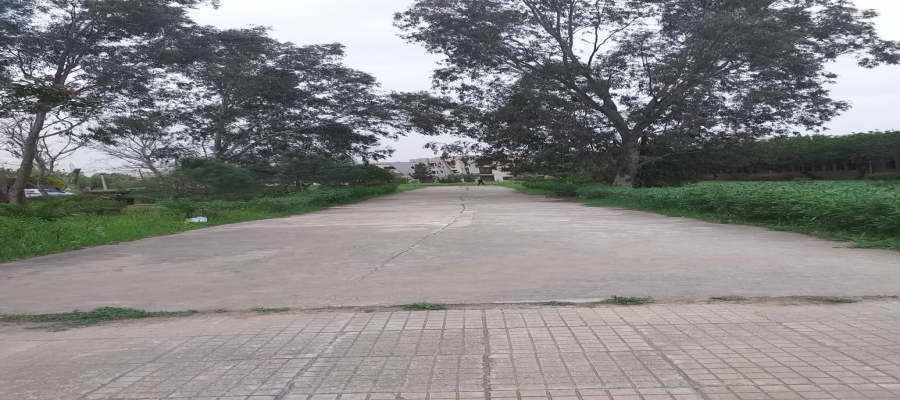

In [ ]:
im= cv2.imread("./es1.jpg")
im = cv2.resize(im, (900, 400), interpolation= cv2.INTER_AREA)
cv2_imshow(im)


##detection avec detectron2

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
# Object Detection
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

#fait appel à des filtres
#Choisir un modèle et son fichier de configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
# spécifier MODEL.WEIGHTSun modèle de zoo de modèles pour évaluation.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
predictions, segmentInfo = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)

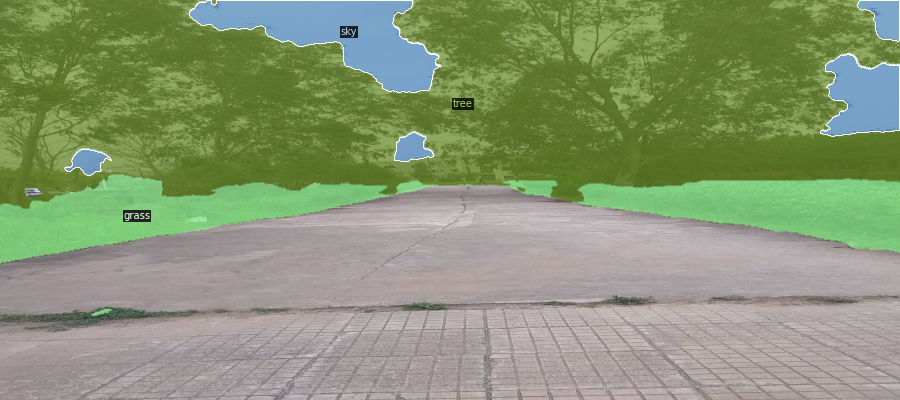

In [ ]:
out = v.draw_panoptic_seg_predictions(predictions.to("cpu"), list(filter(lambda x: x['category_id'] != 21 and x['category_id'] != 44 and x['category_id'] != 0 and x['category_id'] != 2 and x['category_id'] != 1, segmentInfo)), area_threshold=.1)
cv2_imshow(out.get_image()[:, :, ::-1])

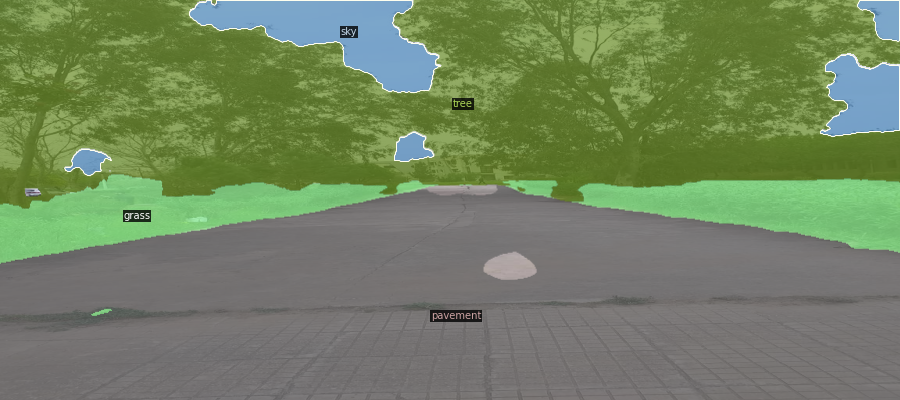

In [ ]:
predictions, segmentInfo = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out2 = v.draw_panoptic_seg_predictions(predictions.to("cpu"), list(filter(lambda x:  x['category_id'] != 0 and x['category_id'] != 2 and x['category_id'] != 1, segmentInfo)), area_threshold=.1)
cv2_imshow(out2.get_image()[:, :, ::-1])

##Traitement sur l'image

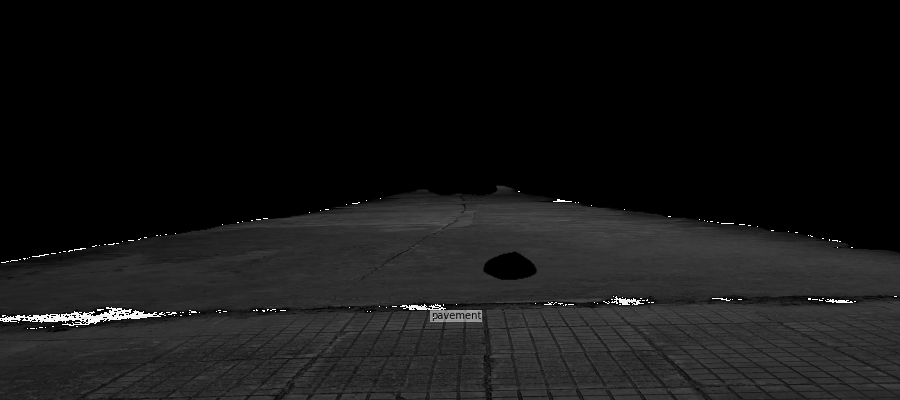

In [ ]:
#soustraction
gray = soustragray(out.get_image(),out2.get_image())
cv2_imshow(gray)

In [ ]:
#image to matrice
np_img =imagetomatrice(gray)

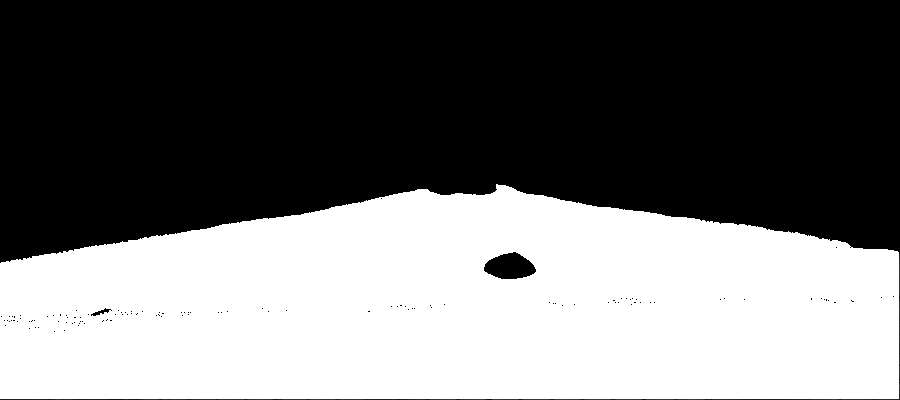

In [ ]:
#pixels route=blanc
transformerpixelsblanc(np_img)
cv2_imshow(np_img)

In [ ]:
affRoute=np_img

In [ ]:
#enlever le bruit
fgmask = enleverbruit(np_img)
cv2_imshow(fgmask)

In [ ]:
#squelette
skel=squelette(fgmask)
affSquelette=skel
cv2_imshow(skel)

In [ ]:
#dilate et couper la photo
d_im=dilate_crop(skel)
cv2_imshow(d_im)

In [ ]:
#eliminer les pixels externe
img2=eliminate(d_im)
cv2_imshow(img2)

In [ ]:
#image to matrice
np_imh=imagetomatrice(img2)

##Nombre de région init

In [ ]:
#nb regions init
listef=[]
listefr=[]
matriceclasse(np_img,listef,listefr)
valeurdouble(listef,listefr)
remplacedeVal(np_img,listef,listefr)
listeregion=[]
calculregion(np_img,listeregion)
nb=len(listeregion)

In [ ]:
print(nb)

1


##Récuperation de x et y, regression linéaire

In [ ]:
#recuperation des points
axex=[]
axey=[]
for i in range(0,len(listeregion)):
     sauvij(np_img,listeregion,axex,axey)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/shapely/geometry/linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


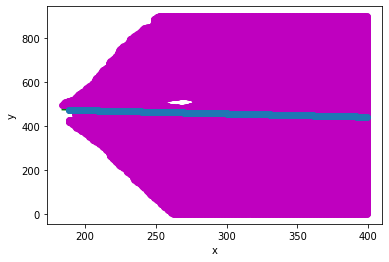

In [ ]:
#regression linéaire
if(len(listeregion)==0):
  print('refaire l image')
else: 
  xint=[]
  yint=[]
  x = np.array(axex) 
  y = np.array(axey) 
  
  b = estimate_coef(x, y) 
  x,y=plot_regression_line(x, y, b,xint,yint) 

##Nombre de région final

In [ ]:
#recalcule nb regions
listeid=id_intersect(listeregion,x,y,np_img)
min=0
min=minimum_id(listeid)
if min!=0:
   remplacedeVal_int(np_img,listeid,min)
listeregionnv=[]
calculregion(np_img,listeregionnv)
nb2=len(listeregionnv)

In [ ]:
print(nb2)

1


#Affichage

In [ ]:
#Résultat en sortie
# create figure
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor( 'black')
fig.patch.set_alpha( 0.4)



# setting values to rows and column variables
rows = 2
columns = 2

# reading images
affImage =cv2.resize(im, (300, 200), interpolation= cv2.INTER_AREA)
affRoute= cv2.resize(affRoute, (300, 200), interpolation= cv2.INTER_AREA)
affSquelette= cv2.resize(affSquelette, (300, 200), interpolation= cv2.INTER_AREA)

plt.title("Nos traitements",fontsize = 30, x = 0.5, y = 1.2,fontweight = 'bold',family = 'sans-serif')
plt.axis('off')
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(cv2.cvtColor(affImage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image prise",fontsize = 20, x = 0.5, y = 1.1,fontweight = 'bold',family = 'sans-serif')

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(cv2.cvtColor(affRoute, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image route",fontsize = 20, x = 0.5, y = 1.01,fontweight = 'bold',family = 'sans-serif')

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(affSquelette, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image squelette",fontsize = 20, x = 0.5, y = 1.01,fontweight = 'bold',family = 'sans-serif')



# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 4)

# showing image

plt.axis('off')
plt.title("Type",fontsize = 20, x = 0.5, y = 1.01,fontweight = 'bold',family = 'sans-serif')
